In [229]:
!pip install deeppavlov

  Using cached deeppavlov-0.14.1-py3-none-any.whl (988 kB)
  Using cached uvicorn-0.11.7-py3-none-any.whl (43 kB)
  Using cached uvloop-0.14.0.tar.gz (2.0 MB)


    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Daria\\AppData\\Local\\Temp\\pip-install-_8h3itks\\uvloop\\setup.py'"'"'; __file__='"'"'C:\\Users\\Daria\\AppData\\Local\\Temp\\pip-install-_8h3itks\\uvloop\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Daria\AppData\Local\Temp\pip-pip-egg-info-7i0wmdej'
         cwd: C:\Users\Daria\AppData\Local\Temp\pip-install-_8h3itks\uvloop\
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\Daria\AppData\Local\Temp\pip-install-_8h3itks\uvloop\setup.py", line 15, in <module>
        raise RuntimeError('uvloop does not support Windows at the moment')
    RuntimeError: uvloop does not support 

In [230]:
!python3 -m deeppavlov install levenshtein_corrector_ru

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [231]:
from deeppavlov import build_model, configs

CONFIG_PATH = configs.spelling_correction.levenshtein_corrector_ru

spellcheck_model = build_model(CONFIG_PATH, download=True)

ModuleNotFoundError: No module named 'deeppavlov'

In [255]:
from nltk.corpus import stopwords


stop = stopwords.words('russian')


def delete_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop])
    

pulse = pd.read_csv("pulse_stage1_patch.csv")
pulse['message'] = pulse['message'].apply(delete_stopwords)
pulse

,message,label,split
0,Пиздабол ещё,True,train
1,"Заколебали кукарекать, скоро весь пульс этими ...",True,train
2,На деле собака сутулая,True,train
3,Пшнх сюда тварь,True,train
4,"плати мое молчание клоп , сутки молчу 200 баксов",True,train
...,...,...,...
34602,"Тут то, ТА работает, здравый смысл отсутствует",False,train
34603,Я бакс 30 верил Когда 50 стоил???,False,train
34604,"Ахаха, тока щас заметил это гавно комиссии кон...",False,train
34605,"Я Теслой месяц мучился плечом , итоге норм , д...",False,train


In [242]:
import pandas as pd
import re

from sklearn.decomposition import PCA, TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
# from sklearn.semi_supervised import LabelSpreading
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from pymystem3 import Mystem
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
# from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [251]:
pulse = pd.read_csv("pulse_stage1_patch.csv")
pulse['label'] = pulse['label'].astype(int)
pulse

,message,label,split
0,Пиздабол ещё тот,1,train
1,"Заколебали кукарекать, скоро весь пульс будет ...",1,train
2,На деле собака сутулая,1,train
3,Пшнх от сюда тварь,1,train
4,"плати за мое молчание клоп , сутки молчу 200 б...",1,train
...,...,...,...
34602,"Тут не то, что ТА не работает, здравый смысл о...",0,train
34603,Я тоже в бакс по 30 верил\nКогда он уже 50 сто...,0,train
34604,"Ахаха, тока щас заметил что за это гавно комис...",0,train
34605,"Я с Теслой месяц мучился с плечом , в итоге вс...",0,train


In [240]:
def lemmatizer(x):
    lemmatizer = WordNetLemmatizer()
    verb = wordnet.VERB
    lems = ''
    words = x.split(' ')
    for word in words:
        lems += lemmatizer.lemmatize(word, verb) + ' '
    return lems[:-1]


lemmatizer('tables')

'table'

In [234]:
def prepare_preproc_and_features(pulse):

    def remove_mentions(s: str):
        return ' '.join(i if not i.startswith('@') else 'юзернейм' for i in s.split(' '))


    def remove_stocks(s: str):
        return ' '.join(i if not i.startswith('{$') else 'актионнейм' for i in s.split(' '))


    def get_caps_feature(text):
        upper = re.sub('[^А-Я]+', '', text)
        return len(upper)


    def get_actions(text):
        return text.count('актионнейм')


    def get_mentions(text):
        return text.count('юзернейм')


    def text_preprocessing(text):
        if type(text) == str:
            text = re.sub(re.compile('<.*?>'), '', text)
            text = re.sub('[^A-Za-zА-Яа-я]+', ' ', text)
            text = text.lower()
        else: 
            text = ''
        return text


    def compare_messages(before, after):
        return 0


    def lemmatizer(x):
        lemmatizer = WordNetLemmatizer()
        verb = wordnet.VERB
        lems = ''
        words = x.split(' ')
        for word in words:
            lems += lemmatizer.lemmatize(word, verb) + ' '
        return lems


    pronomens = {
        'pr1': ['я', 'мой', 'меня'],
        'pr2': ['ты', 'твой', 'тебя'],
        'pr3': ['себя'],
        'pr4': ['мы', 'наш', 'нас'],
        'pr5': ['вы', 'ваш', 'вас'],
        'pr6': ['он', 'она', 'они', 'оно', 'её', 'его', 'их']
    }

    
    def compute_pronomens(text):
        result = []
        words = text.split()
        for key in pronomens.keys():
            pr_count = 0
            for word in pronomens[key]:
                pr_count += text.count(word)
            result.append(pr_count)
        return result


    def count_words(text):
        return len(text.split())
    

    # Замена имён и акций, добавить замену ссылок и смайлов на их названия, подсчёт количества символов
    pulse['n_words'] = pulse['message'].apply(count_words)
    pulse['message'] = pulse['message'].apply(remove_mentions).apply(remove_stocks)

    pulse['caps_lock'] = pulse['message'].apply(get_caps_feature)
    pulse['mentions'] = pulse['message'].apply(get_mentions)
    pulse['actions'] = pulse['message'].apply(get_actions)
    # Добавить ссылки и смайлики

    # Удаление лишних символов и вычисление длины строки
    pulse['message'] = pulse['message'].apply(text_preprocessing)
    pulse['length'] = pulse['message'].str.len()

    # Здесь добавить исправление грамотности и сравнение грамотных сообщений с предыдущими

    # Леммы
    pulse['message'] = pulse['message'].apply(lemmatizer)

    # Удалить пустые
    pulse = pulse[pulse['n_words'] != 0]

    # Подсчёт местоимений
    pr_features = pd.DataFrame(pulse['message'].apply(compute_pronomens).to_list(), columns=pronomens.keys())
    pulse = pulse.join(pr_features)


    # Деление на количество слов нужных колонок
    columns = ['mentions', 'actions', 'pr1', 'pr2', 'pr3', 'pr4', 'pr5', 'pr6', 'caps_lock']
    for c in columns:
        pulse[c] = pulse[c] / pulse['n_words']
    
    return pulse


pulse = pd.read_csv("pulse_stage1_patch.csv")
pulse['label'] = pulse['label'].astype(int)
pulse = prepare_preproc_and_features(pulse)
pulse

,message,label,split,n_words,caps_lock,mentions,actions,length,pr1,pr2,pr3,pr4,pr5,pr6
0,пиздабол ещ тот,1,train,3,0.333333,0.0,0.0,15,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,заколебали кукарекать скоро весь пульс будет э...,1,train,9,0.111111,0.0,0.0,67,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,на деле собака сутулая,1,train,4,0.250000,0.0,0.0,22,0.250000,0.0,0.0,0.0,0.000000,0.000000
3,пшнх от сюда тварь,1,train,4,0.250000,0.0,0.0,18,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,плати за мое молчание клоп сутки молчу баксов,1,train,10,0.000000,0.0,0.0,45,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34602,тут не то что та не работает здравый смысл отс...,0,train,10,0.300000,0.0,0.0,54,0.000000,0.0,0.0,0.1,0.100000,0.000000
34603,я тоже в бакс по верил когда он уже стоил,0,train,12,0.166667,0.0,0.0,42,0.083333,0.0,0.0,0.0,0.000000,0.083333
34604,ахаха тока щас заметил что за это гавно комисс...,0,train,18,0.222222,0.0,0.0,109,0.111111,0.0,0.0,0.0,0.000000,0.055556
34605,я с теслой месяц мучился с плечом в итоге все ...,0,train,21,0.095238,0.0,0.0,102,0.190476,0.0,0.0,0.0,0.047619,0.000000


1. Построить простую модель
2. Попробовать прероцессинг
3. Поправить орфографию
4. Попробовать лемматизацию

In [227]:
def test_model(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    score = []
    roc_auc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score.append(f1_score(y_test, preds))
        roc_auc.append(roc_auc_score(y_test, preds))
    return score, roc_auc

In [228]:
model = RandomForestClassifier()
test_model(model, pulse[['n_words', 'caps_lock', 'mentions', 'actions', 'length']], pulse['label'])

([0.031007751937984496,
  0.04528301886792453,
  0.053030303030303025,
  0.05555555555555555,
  0.031007751937984496],
 [0.5068660015645623,
  0.5108423883131792,
  0.5131844346410626,
  0.5140808936280639,
  0.5068296020193919])

In [48]:
model = Pipeline([('tfid', TfidfVectorizer(max_features=1000)), ('cl', LogisticRegression(solver='lbfgs', n_jobs=-1))])
test_model(model, df['message'], df['label'])

([0.0967741935483871,
  0.06557377049180328,
  0.09756097560975609,
  0.09448818897637794,
  0.04201680672268908],
 [0.5256902226475343,
  0.5169565981933859,
  0.5258780888609034,
  0.5252944880438621,
  0.5106001617700511])

In [81]:
# def text_preprocessing(text):
#     if type(text) == str:
#         text = re.sub(re.compile('<.*?>'), '', text)
# #         text = text.replace("?", " ?")
# #         text = text.replace("!", " !")
#         text = re.sub('[^A-Za-zА-Яа-я]+', ' ', text)
#         text = text.lower()
#     else: 
#         text = ''
#     return text

In [42]:
df['message'] = df['message'].apply(text_preprocessing)

In [43]:
df

,message,label,split
0,пиздабол ещ тот,True,train
1,заколебали кукарекать скоро весь пульс будет э...,True,train
2,на деле собака сутулая,True,train
3,пшнх от сюда тварь,True,train
4,плати за мое молчание клоп сутки молчу баксов,True,train
...,...,...,...
35407,тут не то что та не работает здравый смысл отс...,False,train
35408,я тоже в бакс по верил когда он уже стоил,False,train
35409,ахаха тока щас заметил что за это гавно комисс...,False,train
35410,я с теслой месяц мучился с плечом в итоге все ...,False,train


In [44]:
model = Pipeline([('tfid', TfidfVectorizer(max_features=1000)), ('cl', LogisticRegression(solver='lbfgs', n_jobs=-1))])
test_model(model, df['message'], df['label'])

([0.0502092050209205,
  0.08943089430894309,
  0.13385826771653542,
  0.11811023622047244,
  0.04065040650406503],
 [0.5128086362727022,
  0.5235797666361274,
  0.5366241508352146,
  0.5320922857186737,
  0.51001656095301])

In [10]:
def lemmatizer(x):
    lemmatizer = WordNetLemmatizer()
    verb = wordnet.VERB
    lems = ''
    words = x.split(' ')
    for word in words:
        lems += lemmatizer.lemmatize(word, verb) + ' '
    return lems

In [11]:
df['message'] = df['message'].apply(lemmatizer)

In [10]:
df

,message,label,split
0,пиздабол ещ тот,True,train
1,заколебали кукарекать скоро весь пульс будет э...,True,train
2,на деле собака сутулая,True,train
3,пшнх от сюда тварь,True,train
4,плати за мое молчание клоп сутки молчу 200 бак...,True,train
...,...,...,...
35407,тут не то что та не работает здравый смысл отс...,False,train
35408,я тоже в бакс по 30 верил когда он уже 50 стои...,False,train
35409,ахаха тока щас заметил что за это гавно комисс...,False,train
35410,я с теслой месяц мучился с плечом в итоге все ...,False,train


In [57]:
df[df['message'].contains('a')]

AttributeError: 'Series' object has no attribute 'contains'

In [13]:
# model = Pipeline([('tfid', TfidfVectorizer(max_features=10000, stop_words=stopwords.words('russian'))),
#                   ('cl', LogisticRegression(solver='lbfgs', n_jobs=-1))])
# test_model(model, df['message'], df['label'])

([0.18241042345276873,
  0.08368200836820082,
  0.10743801652892561,
  0.09205020920502091,
  0.1],
 [0.5574878660725322,
  0.5218340611353712,
  0.5284358218276944,
  0.5241228070175439,
  0.5263157894736842])

In [53]:
model = Pipeline([('tfid', TfidfVectorizer(max_features=10000, stop_words=stopwords.words('russian'))),
                  ('cl', RandomForestClassifier())])
test_model(model, df['message'], df['label'])

([0.4294117647058824,
  0.4107142857142857,
  0.41590214067278286,
  0.40828402366863903,
  0.3769968051118211],
 [0.6566165424072641,
  0.6478829179531156,
  0.6468613538515094,
  0.6483248352863483,
  0.6274892622568969])

In [58]:
model = Pipeline([('tfid', TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(4,7))),
                  ('cl', RandomForestClassifier())])
test_model(model, df['message'], df['label'])

([0.2698961937716263,
  0.27814569536423844,
  0.22996515679442509,
  0.25170068027210885,
  0.23487544483985764],
 [0.5836208862832146,
  0.5894416036025245,
  0.5704717183972479,
  0.5790247979154188,
  0.5709094190100288])

In [78]:

pulse

,message,label,split,mean_length
0,Пиздабол ещё тот,1,train,16
1,"Заколебали кукарекать, скоро весь пульс будет ...",1,train,68
2,На деле собака сутулая,1,train,22
3,Пшнх от сюда тварь,1,train,18
4,"плати за мое молчание клоп , сутки молчу 200 б...",1,train,51
...,...,...,...,...
34602,"Тут не то, что ТА не работает, здравый смысл о...",0,train,56
34603,Я тоже в бакс по 30 верил\nКогда он уже 50 сто...,0,train,50
34604,"Ахаха, тока щас заметил что за это гавно комис...",0,train,114
34605,"Я с Теслой месяц мучился с плечом , в итоге вс...",0,train,108


(array([660., 288., 103.,  36.,  18.,  10.,   6.,   8.,   7.,   5.]),
 array([  3. ,  47.7,  92.4, 137.1, 181.8, 226.5, 271.2, 315.9, 360.6,
        405.3, 450. ]),
 <BarContainer object of 10 artists>)

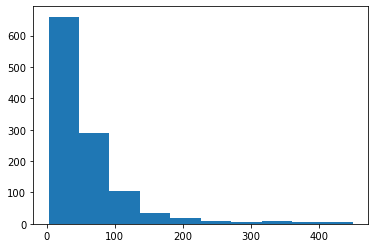

In [79]:
from matplotlib import pyplot as plt

plt.hist(pulse[pulse['label'] == 1]['mean_length'])

(array([ 8353., 10307.,  6139.,  3432.,  2129.,  1214.,   767.,   495.,
          366.,   264.]),
 array([  3. ,  52.7, 102.4, 152.1, 201.8, 251.5, 301.2, 350.9, 400.6,
        450.3, 500. ]),
 <BarContainer object of 10 artists>)

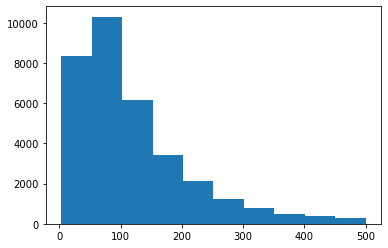

In [80]:
plt.hist(pulse[pulse['label'] == 0]['mean_length'])